In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from nltk.corpus import stopwords

In [3]:
stop_words = stopwords.words('spanish')

In [4]:
pd.options.display.max_rows = 30

In [5]:

df_townstate = pd.read_csv('input/town_state.csv.gz', compression='gzip')
df_townstate['bimbo'] = df_townstate.Town.str.contains('BIMBO') * 1
df_townstate['ag'] = df_townstate.Town.str.contains('AG.') * 1

In [6]:
df_producto['short_names'] = df_producto.NombreProducto.str.extract('^(\D*)')

In [7]:
df_producto['short_names_processed'] = df_producto['short_names'].map(lambda x: " ".join([i for i in x.lower().split() if i not in stopwords.words('spanish')]))

In [8]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("spanish")
print(stemmer.stem("Tortillas"))

tortill


In [9]:
df_producto['short_names_processed'] = (df_producto['short_names_processed']
                                        .map(lambda x: " ".join([stemmer.stem(i) for i in x.lower().split()])))



In [10]:
df_aux_producto = df_producto['short_names_processed'].value_counts()[df_producto['short_names_processed'].value_counts() > 10].reset_index()

In [11]:
df_producto['flavor_choc'] = df_producto.short_names_processed.str.contains('choc') * 1
df_producto['flavor_vainill'] = df_producto.short_names_processed.str.contains('vainill') * 1
df_producto['flavor_canel'] = df_producto.short_names_processed.str.contains('canel') * 1

In [12]:
df_producto['NombreProducto'] = df_producto['NombreProducto'].str.upper()
df_producto['NombreProducto'] = df_producto.apply(lambda x :x['NombreProducto'].replace(str(x['Producto_ID']),'').strip(), axis=1 )
df_producto = pd.DataFrame(df_producto.loc[1:])
df_producto['fabricante'] = df_producto.NombreProducto.str.split(' ').str[-1]
df_producto.ix[df_producto.fabricante == '1KG','fabricante'] = ''
df_producto['NombreProducto'] = df_producto.apply(lambda x :x['NombreProducto'].replace(x['fabricante'],'').strip(), axis=1 )

reg = '(\d{1,4}G|\d{1,4}KG|\d{1,4}ML|\d{1,4}\ ML)'
df_producto['volume'] = df_producto.NombreProducto.str.extract(reg)

df_producto['NombreProducto'] = df_producto.apply(lambda x :x['NombreProducto'].replace(str(x['volume']),'').replace('  ',' ').strip(), axis=1 )

reg = '(\d{1,5}P)'
df_producto['unidade'] = df_producto.NombreProducto.str.extract(reg)
df_producto['NombreProducto'] = df_producto.NombreProducto.str.replace(reg, '').str.replace('  ',' ').str.strip()

aux = pd.DataFrame({'Producto_ID':[0],'NombreProducto':['NO IDENTIFICADO']})
df_producto = df_producto.append(aux)

df_producto['unidade'] = df_producto.volume.str.extract('([A-Z])')
df_producto['volume'] = df_producto.volume.str.replace('([A-Z])','')

# df_producto

In [13]:
df_week = pd.read_csv('input/train_week3.csv')

In [14]:
# df_week.Venta_uni_hoy.hist(range=(0,300), bins=50)

In [15]:
gb = df_week[['Producto_ID','Venta_hoy']].groupby(['Producto_ID']).median().reset_index()
gb[gb['Venta_hoy'] == gb['Venta_hoy'].max()]
aux = df_producto.merge(gb, how='left', on='Producto_ID')
aux.ix[aux['Venta_hoy'].isnull(),'Venta_hoy'] = 0
df_producto = aux

In [16]:
gb = df_week[['Producto_ID','Venta_uni_hoy']].groupby(['Producto_ID']).median().reset_index()
gb[gb['Venta_uni_hoy'] == gb['Venta_uni_hoy'].max()]
aux = df_producto.merge(gb, how='left', on='Producto_ID')
aux.ix[aux['Venta_uni_hoy'].isnull(),'Venta_uni_hoy'] = 0
df_producto = aux

In [17]:
gb = df_week[['Producto_ID','Dev_uni_proxima']].groupby(['Producto_ID']).median().reset_index()
gb[gb['Dev_uni_proxima'] == gb['Dev_uni_proxima'].max()]
aux = df_producto.merge(gb, how='left', on='Producto_ID')
aux.ix[aux['Dev_uni_proxima'].isnull(),'Dev_uni_proxima'] = 0
df_producto = aux

In [18]:
def count_entregas(df, by):
    df['entregas_'+by] = 1
    aux = df.groupby([by]).agg({"entregas_"+by:np.size}).reset_index()
    df.drop('entregas_'+by, axis=1, inplace=True)
    return df.merge(aux, how='left', on=by)

In [19]:
def binarize(df, field, length, step):
    df[field+'_bin']=''
    df[field] = df[field].astype(float)
    for x in range(step, length, step):
        a = df[field] > x - step
        b = df[field] <= x
        f = a & b
        value = '%s-%s' % (x-step, x)
        df.ix[f, field+'_bin'] = value
    print(field+'_bin')
    return df

In [33]:
def process_df(df, test=False):
    
    if not test:
#         df = df.drop(['Venta_uni_hoy','Venta_hoy','Dev_uni_proxima'], axis=1)
        df = df.ix[df.Producto_ID != 0]
        df = df.ix[df.Demanda_uni_equil<20]
        
    df = df.merge(df_producto[['flavor_choc', 'flavor_vainill', 'flavor_canel','volume', 'fabricante','Producto_ID']], how='left',on='Producto_ID')
    df = df.merge(df_townstate[['Agencia_ID','ag','bimbo','State']], on='Agencia_ID')
    df.volume = df.volume.fillna(0).astype('int')

    route_count = df[['Cliente_ID','Ruta_SAK']].groupby(['Cliente_ID']).count().reset_index()
    route_count.columns = ['Cliente_ID','route_client']
    route_count = route_count.ix[route_count['route_client'] <= 60]
    df = df.merge(route_count, how='left', on='Cliente_ID')
    df = df.ix[~df['route_client'].isnull()]
    
    df = df.ix[df.volume<500]
        
    df['Cliente_ID'] = df['Cliente_ID'].astype('str')
    df['Agencia_ID'] = df['Agencia_ID'].astype('str')
    df['Canal_ID'] = df['Canal_ID'].astype('str')
    df['Ruta_SAK'] = df['Ruta_SAK'].astype('str')
        
    f = (df['volume'] < 600)
    df = pd.DataFrame(df.ix[f])
    df = binarize(df, 'volume', 600, 60)
    
#     f = (df['Venta_hoy'] < 60)
#     df = pd.DataFrame(df.ix[f])
#     df = binarize(df, 'Venta_hoy', 60, 12)

#     f = (df['Venta_uni_hoy'] < 10)
#     df = pd.DataFrame(df.ix[f])
#     df = binarize(df, 'Venta_uni_hoy', 10, 2)
    
#     a = df['Venta_uni_hoy_bin'] == ''
#     b = df['Venta_hoy_bin'] == ''
    c = df['volume_bin'] == ''
    df = df.ix[~c]
    
    if test:
        df = df[cols]
    else:
        df = df[cols+['Demanda_uni_equil']].drop_duplicates()
        
#     y = df['Demanda_uni_equil'].values
#     x = pd.get_dummies(aux[cols]).values
#   x = pd.get_dummies(aux[cols]).values
    return df

In [21]:
# df_process['fabricante'].value_counts()

In [22]:
cols = [
#     'volume',
#     'entregas_Producto_ID',
#     'Cliente_ID',
#     'entregas_fabricante',
#     'Agencia_ID',
    'route_client',
#     'Canal_ID',
    'fabricante',
#     'Venta_uni_hoy_bin',
#     'Venta_hoy_bin',
#     'short_names_processed',
    'State',
    'volume_bin',
    'ag',
    'bimbo',
    'flavor_choc',
    'flavor_vainill',
    'flavor_canel',
]

In [ ]:
def process_producto():
    

In [23]:
# aux = df_week.merge(df_townstate, how='left', on='Agencia_ID' )

In [40]:
aux = df_week[['Producto_ID']].merge(df_producto, how='left', on='Producto_ID' )

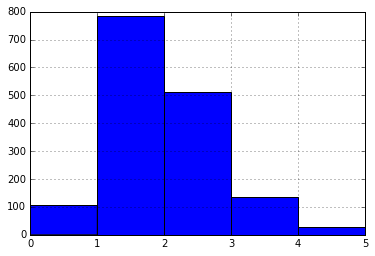

In [72]:
gb= aux[['Producto_ID','Venta_hoy']].groupby('Producto_ID').median().reset_index()
gb['Venta_hoy'] = np.log10(gb['Venta_hoy'].values+1)
gb['Venta_hoy'].hist(range=(0, 5), bins = 5)
df_producto = df_producto.merge(gb, how='left', on='Producto_ID')

,NombreProducto,Producto_ID,fabricante,flavor_canel,flavor_choc,flavor_vainill,short_names,short_names_processed,unidade,volume,Venta_hoy_x,Venta_uni_hoy,Dev_uni_proxima,Venta_hoy_y
0,CAPUCCINO MOKA,9,NES,0,0,0,Capuccino Moka,capuccin mok,G,750,0.000,0.0,0.0,NaN
1,BOLLOS EXT SAJONJOLI,41,BIM,0,0,0,Bimbollos Ext sAjonjoli,bimboll ext sajonjoli,G,480,2084.950,115.0,0.0,3.319304
2,BURRITOS SINCRO CU,53,LON,0,0,0,Burritos Sincro,burrit sincr,G,170,5970.250,417.5,0.0,3.776065
3,DIV TIRA MINI DORADITA,72,TR,0,0,0,Div Tira Mini Doradita,div tir mini doradit,G,45,14.800,4.0,0.0,1.198657
4,PAN MULTIGRANO LINAZA,73,BIM,0,0,0,Pan Multigrano Linaza,pan multigran linaz,G,540,42.640,2.0,0.0,1.639885
5,TOSTADO INTEGRAL,98,WON,0,0,0,Tostado Integral,tost integral,G,180,0.000,0.0,0.0,NaN
6,PAN BLANCO,99,WON,0,0,0,Pan Blanco,pan blanc,G,567,0.000,0.0,0.0,NaN
7,SUPER PAN BCO AJONJOLI SP,100,WON,0,0,0,Super Pan Bco Ajonjoli,sup pan bco ajonjoli,G,680,86.320,4.0,0.0,1.941114
8,DER CT MEDIANO,106,WON,0,0,0,Wonder,wond,G,475,63.120,3.0,0.0,1.806994
9,DER CT GDE SP,107,WON,0,0,0,Wonder,wond,G,680,42.640,2.0,0.0,1.639885


In [64]:
df_producto.merge()

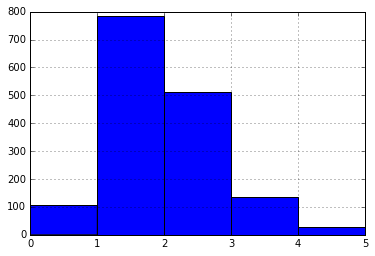

In [25]:
# aux.State.value_counts().plot(kind='bar')

In [26]:
# list(aux.short_names_processed.unique())

In [27]:
# aux = df_week.merge(df_townstate, how='left', on='Agencia_ID')

In [28]:
# aux[['Cliente_ID','Ruta_SAK']].groupby(['Cliente_ID']).count()['Ruta_SAK'].hist(range=(0,60))

KeyError: "['Cliente_ID' 'Ruta_SAK'] not in index"

In [ ]:
# aux.Cliente_ID.unique()[0]

In [ ]:
# df

In [ ]:
# aux.shape

In [ ]:
# enc._n_values

In [29]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

In [30]:
# rf = ExtraTreesRegressor(n_estimators=50, max_features=1.0,min_samples_split=3,n_jobs=4)



def train(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=1729)
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)
    print(mean_squared_error(y_test, y_pred))
        

In [31]:
# df.columns

In [34]:
rf = RandomForestRegressor(n_jobs=4) #, random_state=401

for week in range(3,10):
    df_week = pd.read_csv('input/train_week%s.csv' % week)

    aux = process_df(df_week)
    df = aux.iloc[np.random.permutation(len(aux))]
    df = pd.get_dummies(df)

    print('fitting...')
    # for x in range(10000,df.shape[0]-10000,10000):
    df_partial = df
    x = df_partial.drop(['Demanda_uni_equil'], axis=1).values
    y = df_partial['Demanda_uni_equil'].values
    train(x,y)
    

volume_bin
fitting...
23.2844522712


KeyboardInterrupt: 

In [ ]:
1.12

In [ ]:
df_test

In [ ]:
df_test = pd.read_csv('input/test.csv.gz', compression='gzip')

In [ ]:
df = process_df(df_test, test=True)
# df = aux.iloc[np.random.permutation(len(aux))]
df = pd.get_dummies(df)
res = rf.predict(df.values)

In [ ]:
a = df_test.merge(df_producto, how='left', on='Producto_ID')

In [ ]:
a.Venta_uni_hoy.hist(range=(0,10), bins=2)

In [ ]:
# df_process['short_names_processed']

In [ ]:
# pd.get_dummies(df_process[0:100][cols])

In [ ]:
a = pd.get_dummies(aux[cols])

In [ ]:
rf.feature_importances_.shape

In [ ]:
# a.columns

In [ ]:
a.columns[0]

In [ ]:
plt.bar(range(0,67), height=rf.feature_importances_)

In [ ]:
f = plt.subplots()
i = 444
for v in x.T:
    i+=1
    f.hist(v)

In [ ]:
df.columns

In [ ]:
count_entregas(df, 'Agencia_ID')